# Check if ensembling pays off on rubert-tiny

In [5]:
from datasets import load_dataset

import pandas as pd
import matplotlib.pyplot as plt

In [6]:

# Load the dataset
dataset = load_dataset('dair-ai/emotion')

# Convert to pandas dataframe
train_data = pd.DataFrame(dataset['train'])
val_data = pd.DataFrame(dataset['validation'])
test_data = pd.DataFrame(dataset['test'])

print(train_data.head())
print(test_data.head())

No config specified, defaulting to: emotion/split
Found cached dataset emotion (/root/.cache/huggingface/datasets/dair-ai___emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd)


  0%|          | 0/3 [00:00<?, ?it/s]

                                                text  label
0                            i didnt feel humiliated      0
1  i can go from feeling so hopeless to so damned...      0
2   im grabbing a minute to post i feel greedy wrong      3
3  i am ever feeling nostalgic about the fireplac...      2
4                               i am feeling grouchy      3
                                                text  label
0  im feeling rather rotten so im not very ambiti...      0
1          im updating my blog because i feel shitty      0
2  i never make her separate from me because i do...      0
3  i left with my bouquet of red and yellow tulip...      1
4    i was feeling a little vain when i did this one      0


In [7]:
train_data['label'].value_counts()

1    5362
0    4666
3    2159
4    1937
2    1304
5     572
Name: label, dtype: int64

In [8]:
train_data = train_data.drop_duplicates(subset='text')
train_data = train_data.reset_index(drop=True)

In [9]:
train_data.isna().values.any()

False

In [10]:
train_data['len'] = [len(text.split()) for text in train_data['text']]

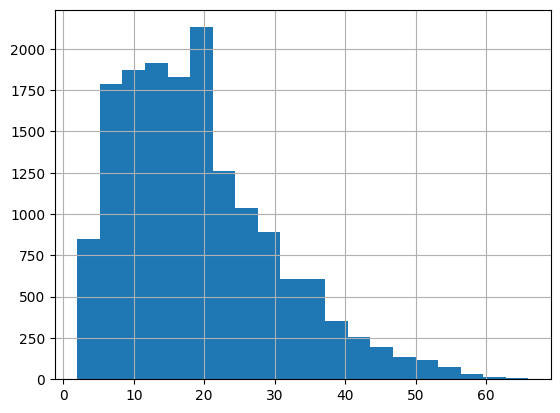

In [11]:
train_data['len'].hist(bins=20)
plt.show()

# Training

In [14]:
from transformers import BertForSequenceClassification, AutoTokenizer
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import f1_score, accuracy_score, classification_report
from IPython.display import clear_output
from tqdm.notebook import tqdm
from sklearn.model_selection import StratifiedKFold




import torch
import torch.nn as nn
import numpy as np


In [15]:
%%capture
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2-cedr-emotion-detection")
model = BertForSequenceClassification.from_pretrained("cointegrated/rubert-tiny2-cedr-emotion-detection", num_labels=6)


In [16]:
import torch
class CustomDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

In [21]:
device = torch.device('cuda:4')
# device = torch.device('cpu')
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

epochs = 15
best_score = 0

Fold:  2
Epoch:  14
166


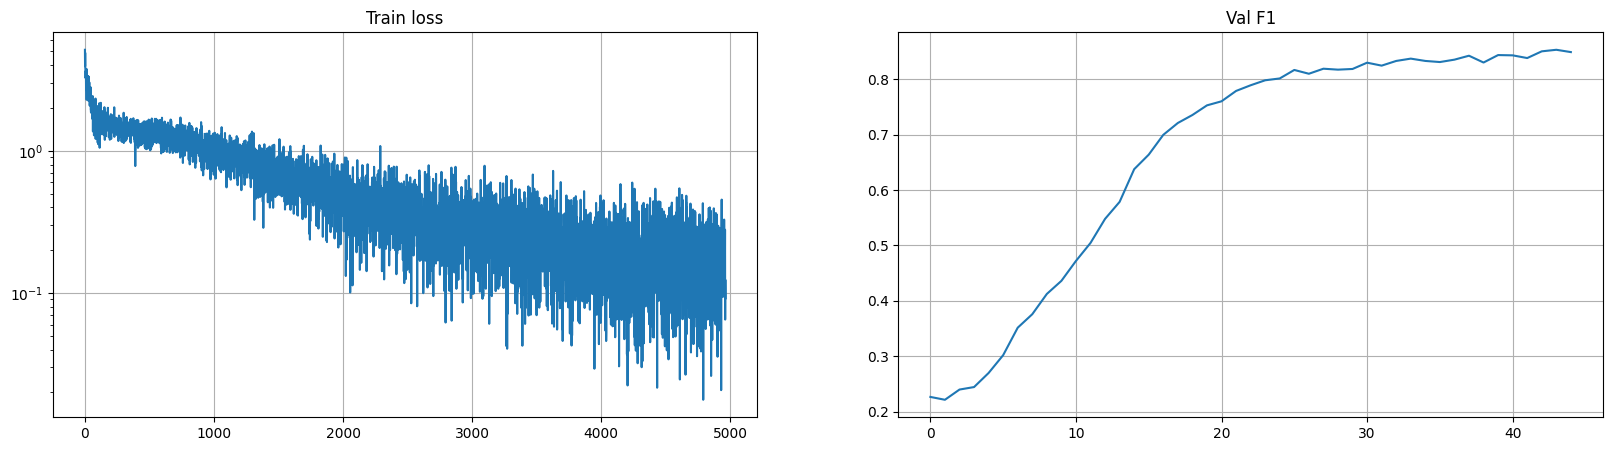

In [22]:
n=3
kf = StratifiedKFold(n_splits=n, random_state=42, shuffle=True)

for fold, (train_index, val_index) in enumerate(kf.split(train_data['text'], train_data['label'])):
    train_df = train_data.iloc[train_index]
    val_df = train_data.iloc[val_index]
    
    train_dataset = CustomDataset(list(train_df['text']), list(train_df['label']))
    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    
    val_dataset = CustomDataset(list(val_df['text']), list(val_df['label']))
    val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)
    
    model = BertForSequenceClassification.from_pretrained("cointegrated/rubert-tiny2-cedr-emotion-detection", num_labels=6)
    model.train()
    model.to(device)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
    
    torch.cuda.empty_cache()
    
    epochs = 15
    best_score = 0
    
    train_loss = []
    val_metrics = []
    
    for epoch in range(epochs):
        for i, batch in enumerate(train_dataloader):
            inputs = tokenizer(list(batch[0]), 
                               max_length=512, 
                               truncation=True,
                               padding='longest',
                               return_tensors='pt').to(device)
            logits = model(**inputs).logits
            loss = nn.CrossEntropyLoss()(logits, batch[1].to(device))
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

            train_loss.append(loss.item())

            if i % 100 == 0 and i != 0:
                labels = np.array([])
                preds = np.array([])
                for i, batch in enumerate(tqdm(val_dataloader)):
                    inputs = tokenizer(list(batch[0]), 
                                       max_length=512, 
                                       truncation=True,
                                       padding='longest',
                                       return_tensors='pt').to(device)
                    with torch.no_grad():
                        preds = np.append(preds,
                                        torch.argmax(model(**inputs).logits, axis=1).cpu().numpy())
                    labels = np.append(labels, batch[1].numpy())

                score = f1_score(preds, labels, average='macro')
                if score > best_score:
                    model.save_pretrained(f'rubert-tiny-emotions-{fold}')
                    tokenizer.save_pretrained(f'rubert-tiny-emotions-{fold}')
                    best_score = score

                val_metrics.append(score)

                #print plots
                clear_output()
                print('Fold: ', fold)
                print('Epoch: ', epoch)
                print(i)
                plt.figure(figsize=(20,5))
                plt.subplot(121)
                plt.semilogy(train_loss)
                plt.title('Train loss')
                plt.grid(True)
                plt.subplot(122)
                plt.plot(val_metrics)
                plt.title('Val F1')
                plt.grid(True)
                plt.show()











# Inference with ensemble of models
## Validation data

In [25]:
val_dataset = CustomDataset(val_data['text'], val_data['label'])
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [26]:
num_of_models = 3
all_logits = []
for i in range(num_of_models):
    model = BertForSequenceClassification.from_pretrained(f'rubert-tiny-emotions-{i}')
    model.eval()
    model.to(device)
    logits = []
    labels = np.array([])
    preds = torch.empty([0,6])
    for i, batch in enumerate(tqdm(val_dataloader)):
        inputs = tokenizer(list(batch[0]), 
                           max_length=512, 
                           truncation=True,
                           padding='longest',
                           return_tensors='pt').to(device)
        with torch.no_grad():
            logits = model(**inputs).logits
            preds = torch.cat([preds, logits.cpu()])
#     logits = np.squeeze(np.array(logits), 1)
    all_logits.append(preds.numpy())
avg_logits = np.mean(np.array(all_logits), axis=0)
preds = np.argmax(avg_logits, axis=1)

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

In [27]:
f1_score(preds, val_data['label'], average='macro')

0.8746963558642947

In [28]:
#val data
names = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}
report = classification_report(preds, val_data['label'], output_dict=True, target_names=names.values())#, target_names=[high_lbls]
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
sadness,0.934545,0.929476,0.932004,553.000
joy,0.911932,0.942731,0.927076,681.000
love,0.825843,0.849711,0.837607,173.000
anger,0.901818,0.885714,0.893694,280.000
fear,0.882075,0.834821,0.857798,224.000
surprise,0.839506,0.764045,0.800000,89.000
accuracy,0.903000,0.903000,0.903000,0.903
macro avg,0.882620,0.867750,0.874696,2000.000
weighted avg,0.902755,0.903000,0.902612,2000.000


## Test data

In [29]:
test_dataset = CustomDataset(test_data['text'], test_data['label'])
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [30]:
num_of_models = 3
all_logits = []
for i in range(num_of_models):
    model = BertForSequenceClassification.from_pretrained(f'rubert-tiny-emotions-{i}')
    model.eval()
    model.to(device)
    logits = []
    labels = np.array([])
    preds = torch.empty([0,6])
    for i, batch in enumerate(tqdm(test_dataloader)):
        inputs = tokenizer(list(batch[0]), 
                           max_length=512, 
                           truncation=True,
                           padding='longest',
                           return_tensors='pt').to(device)
        with torch.no_grad():
            logits = model(**inputs).logits
            preds = torch.cat([preds, logits.cpu()])
#     logits = np.squeeze(np.array(logits), 1)
    all_logits.append(preds.numpy())
avg_logits = np.mean(np.array(all_logits), axis=0)
preds = np.argmax(avg_logits, axis=1)

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

In [31]:
f1_score(preds, test_data['label'], average='macro')

0.8584382929269484

In [35]:
#test data
names = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}
report = classification_report(preds, test_data['label'], output_dict=True, target_names=names.values())#, target_names=[high_lbls]
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
sadness,0.934596,0.964476,0.949301,563.0000
joy,0.910791,0.944776,0.927473,670.0000
love,0.817610,0.734463,0.773810,177.0000
anger,0.909091,0.902527,0.905797,277.0000
fear,0.910714,0.839506,0.873662,243.0000
surprise,0.742424,0.700000,0.720588,70.0000
accuracy,0.904500,0.904500,0.904500,0.9045
macro avg,0.870871,0.847625,0.858438,2000.0000
weighted avg,0.903108,0.904500,0.903237,2000.0000
